## Accelerating Insights in the M5 Forecasting Competition with Polars: Unleashing the Power of Efficient Data Preprocessing"

### Introduction
In the fast-paced world of retail analytics, where vast datasets are the norm, efficient data preprocessing is the cornerstone of precise forecasting. In this article, we embark on an journey into the realm of data preprocessing for the M5 Forecasting Competition, utilizing the Walmart dataset. What sets this expedition apart is our choice of the Polars library, a high-performance DataFrame powerhouse, and here's why it reigns supreme, especially when grappling with massive datasets.

#### Polars vs. Pandas
Polars:
Performance: Polars shines when it comes to speed, particularly with large datasets, thanks to its Rust-based core. This means lightning-fast data manipulations.
Lazy Evaluation: Polars adopts a "lazy evaluation" approach, postponing operations until they're absolutely necessary. This strategy enhances efficiency, especially for intricate data transformations.
Ergonomics: Polars offers a more intuitive and concise API, streamlining the process of expressing complex data operations with less code.
Data Types: Polars excels in handling nullable types, which can be crucial when dealing with missing or incomplete data.
Parallel Processing: To further turbocharge performance, Polars leverages multi-threading for parallel execution of operations.

Pandas:
Maturity: Pandas stands as a venerable library with a massive user base. It has been battle-tested over the years.
Ecosystem: The Pandas ecosystem is vast, with community-contributed packages extending its functionality for various data analysis tasks.
Flexibility: Pandas is known for its versatility, capable of handling diverse data sources and formats.
Integration: It seamlessly integrates with other popular data science libraries such as NumPy, Matplotlib, and Scikit-Learn.

In summary, Polars excels in terms of performance, lazy evaluation, and user-friendly design, making it an ideal choice when dealing with large datasets and performance-critical tasks. On the other hand, Pandas offers maturity, a rich ecosystem, and flexibility, making it well-suited for a wide range of data manipulation needs.


#### The M5 Walmart data
In the M5 Forecasting Competition, the provided data consists of several CSV files, each containing different information related to sales, prices, and forecastingformat. Here's a brief summary of the CSV files:
sales_train_validation.csv: This file contains historical daily sales data at the item-store level. It includes information on item IDs, store IDs, and daily sales for multiple days. This data serves as the primary dataset for building forecasting models.

calendar.csv: The calendar file provides information about dates, including details such as the day of the week, month, and year. It also includes special events and holidays, which can be used to incorporate external factors into forecasting models.

sell_prices.csv: This file contains information about the prices of items in stores. It includes data on item IDs, store IDs, and the corresponding prices for specific dates. Price data is crucial for modeling the relationship between prices and sales.

sales_train_evaluation.csv: Similar to the sales_train_validation.csv file, this file contains historical daily sales data but extends further into the evaluation period. It's used for the final stage of the competition when participants need to make predictions for this extended period.

sample_submission.csv: This file provides a template for submitting forecasts. Participants need to format their predictions according to this template for evaluation.

These CSV files collectively form the core dataset for the M5 Forecasting Competition. We will focus on the following files:
sales_train_evaluation.csv
sell_prices.csv
calendar.csv






#### Data pre-processing with Polars

we start by importing the neccesary packages and files

In [3]:
# import libraries
import pandas as pd 
import polars as pl 
import numpy as np 

import seaborn as sns
import matplotlib.pyplot as plt

from datetime import date

# import data from parquet files on gg drive
path_sales    = '/Users/fredrik.hornell/Python/Private/Walmart_M5/data/raw/sales_train_evaluation.parquet'
path_calander = '/Users/fredrik.hornell/Python/Private/Walmart_M5/data/raw/calendar.parquet'
path_price    = '/Users/fredrik.hornell/Python/Private/Walmart_M5/data/raw/sell_prices.parquet'

# read parquet files
df_sales      = pl.read_parquet(path_sales)
df_calendar   = pl.read_parquet(path_calander)
df_price      = pl.read_parquet(path_price)

From df_sales, df_calender we will create the following polars dataframes/tables

- df_point_of_sale: will consist of 3 columns ['id', 'date' , 'sales'], and be transformed into long format. We will  cast the sales columns to int16 to reduce amount of memory needed to handle the new dataframe.


In [4]:
# point_of_sale_dataframe
df_point_of_sale = (
    df_sales.lazy()
    .drop(['item_id','dept_id','cat_id','store_id','state_id'])
    .melt(id_vars = 'id')
    .rename({'variable': 'day', 'value': 'sales'})
    .with_columns(
        [
            pl.col('sales').cast(pl.Int16),
        ]
    )
    .join(df_calendar.select(
            [
              pl.col("date") 
            , pl.col("d").alias("day")
            ]
    ).lazy(), on="day", how="inner")
    .drop(['day'])
    .select(
        pl.col('id')
        , pl.col('date')
        , pl.col('sales')
    )
    .collect()
)

print("""df_sales has shape {}\ndf_point_of_sale has shape{}""".format(df_sales.shape, df_point_of_sale.shape))

df_sales has shape (30490, 1947)
df_point_of_sale has shape(59181090, 3)


In [6]:
# create Prodloc table with prodloc metadata
df_prodloc = (
    df_sales.lazy()
    .select(
        [
             pl.col('id')
            , pl.col('item_id')
            , pl.col('dept_id')
            , pl.col('cat_id')
            , pl.col('store_id')
            , pl.col('state_id')
        ]
    )
    .join(
        df_point_of_sale.lazy()
        , on="id", how="inner"
    )
    .group_by(
        [
             pl.col('id')
            , pl.col('item_id')
            , pl.col('dept_id')
            , pl.col('cat_id')
            , pl.col('store_id')
            , pl.col('state_id')
        ]
    )
    .agg(
        [
             (pl.col("date").filter(pl.col("sales") > 0)).min().alias("first_tran_dt")
            , (pl.col("date").filter(pl.col("sales") > 0 )).max().alias("last_tran_dt")
            , (pl.col("date")).max().alias("dataset_last_dt")
            , pl.col("sales").sum().alias("total_unit_sales")
        ]
    )
    .with_columns(
        (
            pl.col('first_tran_dt')
            .map_elements(lambda x: pl.date_range(x,date(2016, 5, 22), interval="1d", eager=True))
            .alias('timeseries_daterange')
            
        )
    )
    .collect()
)

df_prodloc

/var/folders/vg/gffx6m9j07j37nkdpql4hwr00000gq/T/ipykernel_4457/1194186615.py:44: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  .collect()


id,item_id,dept_id,cat_id,store_id,state_id,first_tran_dt,last_tran_dt,dataset_last_dt,total_unit_sales,timeseries_daterange
str,str,str,str,str,str,date,date,date,i64,list[date]
"""HOUSEHOLD_1_101_TX_1_evaluatio…","""HOUSEHOLD_1_101""","""HOUSEHOLD_1""","""HOUSEHOLD""","""TX_1""","""TX""",2011-06-12,2016-05-22,2016-05-22,760,"[2011-06-12, 2011-06-13, … 2016-05-22]"
"""FOODS_3_287_TX_3_evaluation""","""FOODS_3_287""","""FOODS_3""","""FOODS""","""TX_3""","""TX""",2011-04-15,2016-05-19,2016-05-22,878,"[2011-04-15, 2011-04-16, … 2016-05-22]"
"""FOODS_2_224_WI_3_evaluation""","""FOODS_2_224""","""FOODS_2""","""FOODS""","""WI_3""","""WI""",2011-03-21,2016-05-22,2016-05-22,585,"[2011-03-21, 2011-03-22, … 2016-05-22]"
"""HOBBIES_1_224_CA_3_evaluation""","""HOBBIES_1_224""","""HOBBIES_1""","""HOBBIES""","""CA_3""","""CA""",2012-02-18,2016-05-18,2016-05-22,623,"[2012-02-18, 2012-02-19, … 2016-05-22]"
"""HOUSEHOLD_1_461_TX_2_evaluatio…","""HOUSEHOLD_1_461""","""HOUSEHOLD_1""","""HOUSEHOLD""","""TX_2""","""TX""",2011-01-29,2016-05-22,2016-05-22,3587,"[2011-01-29, 2011-01-30, … 2016-05-22]"
…,…,…,…,…,…,…,…,…,…,…
"""HOUSEHOLD_2_003_WI_1_evaluatio…","""HOUSEHOLD_2_003""","""HOUSEHOLD_2""","""HOUSEHOLD""","""WI_1""","""WI""",2011-01-31,2016-05-21,2016-05-22,525,"[2011-01-31, 2011-02-01, … 2016-05-22]"
"""HOUSEHOLD_1_104_WI_3_evaluatio…","""HOUSEHOLD_1_104""","""HOUSEHOLD_1""","""HOUSEHOLD""","""WI_3""","""WI""",2013-08-17,2016-05-18,2016-05-22,108,"[2013-08-17, 2013-08-18, … 2016-05-22]"
"""FOODS_3_216_WI_2_evaluation""","""FOODS_3_216""","""FOODS_3""","""FOODS""","""WI_2""","""WI""",2012-03-02,2016-05-17,2016-05-22,951,"[2012-03-02, 2012-03-03, … 2016-05-22]"


In [9]:
df_sales = (
    df_prodloc.lazy()
    .select([pl.col('id'), pl.col('timeseries_daterange').alias('date')])
    .explode('date')
    .join(df_point_of_sale.lazy(), on=['id', 'date'], how='inner')
    .collect()
)

df_sales.shape


(46796220, 3)

In [ ]:
print(df_prodloc.select(pl.col('id')).sample(5))

shape: (5, 1)
┌─────────────────────────────────┐
│ id                              │
│ ---                             │
│ str                             │
╞═════════════════════════════════╡
│ FOODS_3_822_CA_4_evaluation     │
│ HOUSEHOLD_1_083_WI_3_evaluation │
│ FOODS_3_814_WI_3_evaluation     │
│ FOODS_2_058_CA_2_evaluation     │
│ HOUSEHOLD_1_397_CA_3_evaluation │
└─────────────────────────────────┘


<AxesSubplot: xlabel='date'>

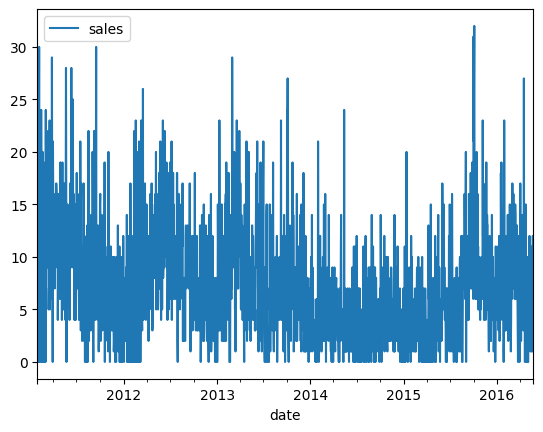

In [ ]:
df_test = (
    df_sales
    .lazy()
    .filter(pl.col('id') == 'HOUSEHOLD_1_083_WI_3_evaluation')
    .collect()
)

df_test.to_pandas().plot(x='date', y='sales')

In [ ]:
df_test

id,date,sales
str,date,i16
"""HOUSEHOLD_1_08…",2011-01-29,15
"""HOUSEHOLD_1_08…",2011-01-30,22
"""HOUSEHOLD_1_08…",2011-01-31,12
"""HOUSEHOLD_1_08…",2011-02-01,0
"""HOUSEHOLD_1_08…",2011-02-02,0
"""HOUSEHOLD_1_08…",2011-02-03,0
"""HOUSEHOLD_1_08…",2011-02-04,17
"""HOUSEHOLD_1_08…",2011-02-05,30
"""HOUSEHOLD_1_08…",2011-02-06,0


### Spectral entropy F

In [ ]:
from statsmodels.tsa.ar_model import ar_select_order
import statsmodels.api as sm
import math
import numpy as np
import pandas as pd


def spec_ar_entropy(x):

    x = uni = np.random.normal(size=10000)
    x = np.sin(np.arange(1, 200))
    order = 25
    n_freq = math.ceil(len(x) / 2) + 1

    if not isinstance(x, pd.Series):
        x = pd.Series(x)

        # select order/lags to use
        mod_lag = ar_select_order(x, maxlag=order, ic="aic", trend="n")
        lags = mod_lag.ar_lags

        # model the data as auto regression
        model = sm.tsa.AutoReg(x, lags=lags)
        result = model.fit()

    # set the frequency
    freq = np.linspace(0, 0.5, num=n_freq)

    # create lags variable to use
    if lags == None:
        lags = 0

    var_p = result.sigma2

    if lags != 0:
        cs = np.dot(
            np.cos(2 * np.pi * np.outer(freq, np.arange(1, len(lags) + 1))),
            result.params[1:],
        )
        sn = np.dot(
            np.sin(2 * np.pi * np.outer(freq, np.arange(1, len(lags) + 1))),
            result.params[1:],
        )
        spec = var_p / (1.0 * ((1 - cs) ** 2 + sn ** 2))
    else:
        spec = np.repeat(var_p / 1.0, len(freq))

    try:
        fx = np.concatenate((np.flip(spec[1:]), spec)) / len(x)
        fx = fx / np.sum(fx)
        prior_fx = np.repeat(1 / len(fx), len(fx))
        prior_weight = 0.0001
        fx = (1 - prior_weight) * fx + prior_weight * prior_fx
        entropy = min(1, -np.sum(fx * np.log(fx) / np.log(len(x))))
    except:
        entropy = np.nan

    return entropy


### Strength of trend F2 and Seasonality 


In [ ]:
import polars as pl
from functime.preprocessing import boxcox, detrend, deseasonalize_fourier, diff, scale, yeojohnson
from functime.plotting import plot_panel, plot_forecasts

x =  df_test

transformer = detrend(freq="1d", method="linear")

transformer_season_year = deseasonalize_fourier(sp=365, K=4)

transformer_season_weekday = deseasonalize_fourier(sp=7, K=3)

x_detrended_deseasonalized = (
    x
    .pipe(transformer)
    .pipe(transformer_season_year)
    .pipe(transformer_season_weekday)
    .collect()
)

x_detrended = (
    x
    .pipe(transformer)
    .collect()
)

x_deseasonalized = (
    x
    .pipe(transformer_season_year)
    .pipe(transformer_season_weekday)
    .collect()
)


var_r = x_detrended_deseasonalized.select(pl.var('sales'))
var_deseasonalized = x_deseasonalized.select(pl.var('sales'))
var_detrended = x_detrended.select(pl.var('sales'))


strength_trend = var_r.select(pl.col('sales')) / var_deseasonalized.select(pl.col('sales'))
strength_seasonal = var_r.select(pl.col('sales')) / var_detrended.select(pl.col('sales'))

### Approximate entropy vs binned entropy

In [ ]:
import polars as pl
from functime.preprocessing import boxcox, detrend, deseasonalize_fourier, diff, scale, yeojohnson
from functime.plotting import plot_panel, plot_forecasts

x =  df_test


In [ ]:
import numpy as np
import polars as pl
from polars import col, lit

from functime.feature_extraction.tsfresh import (
    approximate_entropy,
    benford_correlation,
    binned_entropy,
    autocorrelation,
    cid_ce,
    c3
)

sin_x = pl.Series(np.sin(np.arange(2000)))
x =  df_test.select(pl.col('sales')).to_series()

entropy = (
    approximate_entropy(
       x  = x
       , run_length=5
       , filtering_level=0.0001
    )
)

binned_entropy = (
    binned_entropy(
        x = x
        , bin_count=10
    )
)

c3 = (
    c3(
        x = x
        ,n_lags=28
    )
)

cid_ce = (
  cid_ce(
      x = x 
      , normalize=True
  )  
)
print(entropy)
print(binned_entropy)
print(c3)
print(cid_ce)


0.011488992322677305
1.7614511826130732
507.05145888594166
108.02777


In [ ]:
x

sales
i16
15
22
12
0
0
0
17
30
0


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0050dca7-17b3-44cb-a063-ab0f7808e424' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>